<a href="https://colab.research.google.com/github/Hrithik2212/PyTorch-Deep-Learning-/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Neural Network Classification

## Make classification data and get it ready

In [64]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [65]:
X.shape,y.shape

((1000, 2), (1000,))

In [66]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [67]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

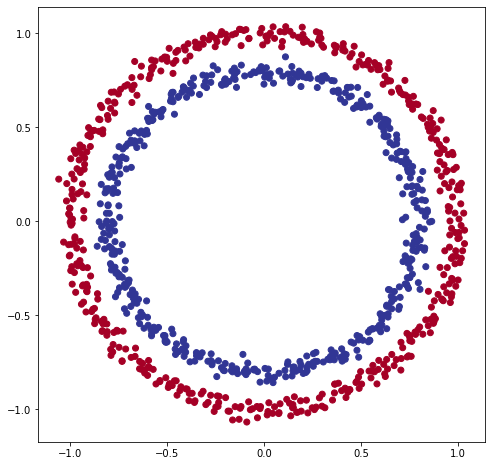

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);


##  Turn data into tensors and create train and test splits

In [69]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [70]:
from sklearn.model_selection import train_test_split
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a Model 

In [71]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [72]:
!CUDA_LAUNCH_BLOCKING=1.

In [73]:
class CircleModelV0(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)
    
  def forward(self,x):
    return self.layer_2(self.layer_1(x))

Model_0 = CircleModelV0().to(device)
Model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [74]:
next(Model_0.parameters())

Parameter containing:
tensor([[-0.3041, -0.0775],
        [-0.5293,  0.6441],
        [-0.5190,  0.3779],
        [ 0.2485,  0.2298],
        [-0.3823,  0.6427]], device='cuda:0', requires_grad=True)

In [75]:
untrained_preds = Model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0004],
        [-0.0377],
        [-0.0430],
        [ 0.0133],
        [-0.2707],
        [-0.2922],
        [-0.2191],
        [-0.2793],
        [-0.0333],
        [-0.0428]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Loss Function and Optimizer

In [76]:
loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(params=Model_0.parameters(), 
                            lr=0.1)
optimizer_2 = torch.optim.SGD(params=Model_0.parameters(), 
                            lr=0.1)

## Creating an Evaluation Metric 

In [77]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Train Model 
1) Forward Pass

2) Calculate Loss

3) Optimizer Zero Grad

4) Loss Backward (Back Propagation)

5) Optimzer step (Gradient Descent)


In [78]:
Model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [79]:
y_logits = Model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0004],
        [-0.0377],
        [-0.0430],
        [ 0.0133],
        [-0.2707]], device='cuda:0', grad_fn=<SliceBackward0>)

In [80]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5001],
        [0.4906],
        [0.4893],
        [0.5033],
        [0.4327]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [81]:
torch.round(y_pred_probs)

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [82]:
y_pred_labels = torch.round(torch.sigmoid(Model_0(X_test.to(device))[:5]))
y_pred_labels

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [83]:
y_pred_labels.squeeze()

tensor([1., 0., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [84]:
!smi nvidia 

/bin/bash: smi: command not found


## Building a Train and Test loop  

In [85]:
torch.manual_seed(42)
epochs = 101
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)
for epoch in range(epochs):
  Model_0.train()
  # Foward Pass
  y_logits = Model_0(X_train).squeeze()
  y_pred = torch.round(y_logits)
  # Calculate Loss and Accuracy 
  loss = loss_fn(torch.sigmoid(y_logits),y_train)

  acc = accuracy_fn(y_train,y_pred)
  # Optimizer Zero Grad
  optimizer_2.zero_grad()

  # Back Propagation 
  loss.backward()

  # Optimizer Gradient Descent 
  with torch.inference_mode():
    # Foward Pasdd
    test_logits = Model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # Calculate Loss and Accuracy 
    test_loss = loss_fn(torch.sigmoid(test_logits),y_test)
    test_acc = accuracy_fn(y_test,test_pred)
    
    if epoch % 10 == 0 :
      print(f"Epoch {epoch}  Loss {loss}  Accuracy {acc}")

Epoch 0  Loss 0.6971250772476196  Accuracy 50.0
Epoch 10  Loss 0.6971250772476196  Accuracy 50.0
Epoch 20  Loss 0.6971250772476196  Accuracy 50.0
Epoch 30  Loss 0.6971250772476196  Accuracy 50.0
Epoch 40  Loss 0.6971250772476196  Accuracy 50.0
Epoch 50  Loss 0.6971250772476196  Accuracy 50.0
Epoch 60  Loss 0.6971250772476196  Accuracy 50.0
Epoch 70  Loss 0.6971250772476196  Accuracy 50.0
Epoch 80  Loss 0.6971250772476196  Accuracy 50.0
Epoch 90  Loss 0.6971250772476196  Accuracy 50.0
Epoch 100  Loss 0.6971250772476196  Accuracy 50.0


## Visualizing predictions

In [86]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


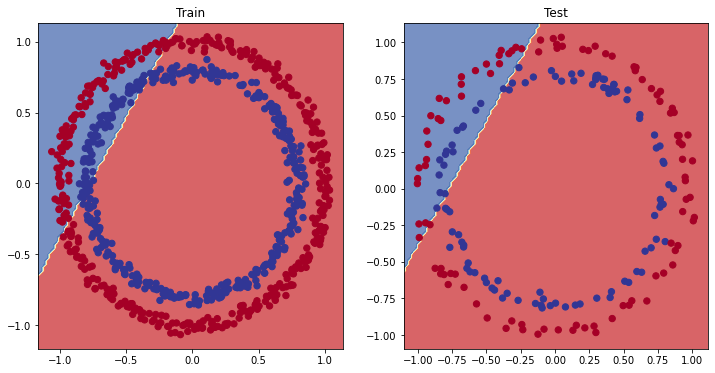

In [87]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(Model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(Model_0, X_test, y_test)

## Improve Model

In [91]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,X):
    return self.layer_3(self.layer_2(self.layer_1(X)))

Model_1 = CircleModelV1().to(device)
Model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.0338,  0.3948, -0.1807, -0.4035, -0.2421, -0.5283,  0.2522,  0.5473,
                      -0.6657,  0.1642], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1634,  0.0573, -0.1126,  0.1651,  0.1662,  0.1182, -0.0556, -0.0837,
                        0.0338, -0.0559],
                      [-0.0942,  0.2021,  0.2718, -0.0313, -0.0708,  0.0046, -0.0189,  0.0760,
                        0.0886, -0.2872],
                      [-0.1167,  0.2663,  0.1232, -0

In [92]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(Model_1.parameters(),
                          lr=0.01)


In [93]:
torch.cuda.manual_seed(42)

epochs =1001
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  Model_1.train()
  # Forward Pass
  y_logits = Model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss and accuracy 

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  # Optimzer Zero grad
  optimizer.zero_grad()

  # Bacck Propagation 
  loss.backward()

  # Gradient Descent 
  optimizer.step()

  ### Testing 
  Model_1.eval()
  with torch.inference_mode():
        # Forward Pass
        test_logits = Model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Calculate Loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

  if (epoch%100==0):
    print(f"Epoch {epoch} Loss {loss} Acc {acc} Test Loss {test_loss} Test Acc {test_acc}")

Epoch 0 Loss 0.6952804327011108 Acc 51.37500000000001 Test Loss 0.6925603151321411 Test Acc 49.5
Epoch 100 Loss 0.6944889426231384 Acc 50.625 Test Loss 0.6923051476478577 Test Acc 51.0
Epoch 200 Loss 0.6940850615501404 Acc 50.24999999999999 Test Loss 0.6922722458839417 Test Acc 50.0
Epoch 300 Loss 0.693838357925415 Acc 49.5 Test Loss 0.6923059821128845 Test Acc 51.0
Epoch 400 Loss 0.6936703324317932 Acc 49.125 Test Loss 0.6923640966415405 Test Acc 50.0
Epoch 500 Loss 0.6935490369796753 Acc 48.875 Test Loss 0.6924333572387695 Test Acc 50.5
Epoch 600 Loss 0.6934583783149719 Acc 49.0 Test Loss 0.6925083994865417 Test Acc 50.5
Epoch 700 Loss 0.693388819694519 Acc 49.0 Test Loss 0.6925860643386841 Test Acc 52.0
Epoch 800 Loss 0.6933344006538391 Acc 48.25 Test Loss 0.6926642656326294 Test Acc 52.5
Epoch 900 Loss 0.6932910084724426 Acc 48.375 Test Loss 0.6927416920661926 Test Acc 52.0
Epoch 1000 Loss 0.6932557821273804 Acc 48.125 Test Loss 0.6928173899650574 Test Acc 51.0


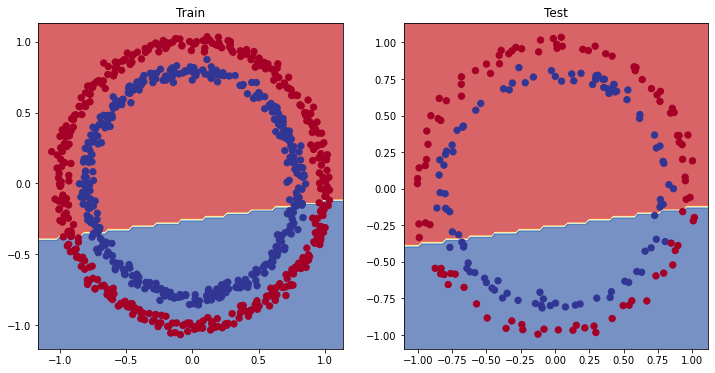

In [94]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(Model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(Model_1, X_test, y_test)

## Improving Model with Activation function 